# Crunching ARCO data and saving results on LEAP-Pangeo

In this tutorial we will see how we can lazily load a gigantic analysis-ready cloud-optimized (ARCO) dataset, apply our custom analysis to it, and save the results to LEAP cloud storage.

## Our Dataset: ARCO ERA5

The dataset we are using is a prime example where the work by some dedicated folks to ingest and transform a dataset to an ARCO zarr store can avoid the toil of downloading/organizing/loading/preprocessing data for many users (in this case all of us). 

We are using [arco-era5](https://github.com/google-research/arco-era5) dataset. This is a great example of public ARCO data, and while it represents a large amount of work (ERA5 is notoriously difficult to download and process), I hope this will convince you of the downstream benefits of work like this and hopefully encourage you to [ingest]() other relevant datasets into the LEAP-Data Library. 

> If everyone does this for their favorite dataset, eventually all data loading becomes as easy as a copy and paste 😜

In [1]:
# Literally copied and pasted this from the repos README
import xarray as xr

ar_full_37_1h = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2/'
)
ar_full_37_1h

<xarray.Dataset>
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 90.0...
  * level                                             (level) int64 1 2 ... 1000
  * longitude                                         (longitude) float32 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 dask.array<chunksize=(1, 37, 721, 1440), meta=np.ndarray>

In [2]:
# how big is this whole thing?
print(f"The full dataset is {ar_full_37_1h.nbytes/1e12}TB large")

The full dataset is 534.392622804012TB large


Ok so it only took us a few seconds to load half a PB? How is that possible?

We are not actually loading the data into memory, instead we are lazily loading the dataset (only loading the dimensions into memory) and get an xarray dataset backed by dask arrays.

## Exploration
The lazy loading enables us to load 'just what we need' for interactive exploration

Loading only 4.15296MB for this plot


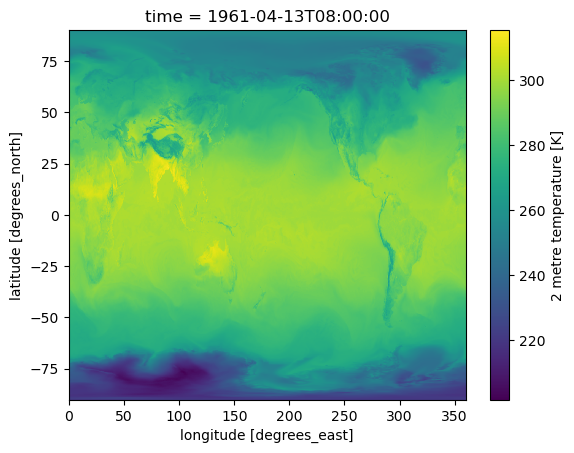

In [3]:
single_slice = ar_full_37_1h['2m_temperature'].isel(time=20000)
print(f"Loading only {single_slice.nbytes/1e6}MB for this plot")
single_slice.plot()

Nice, but ERA5 is pretty high res, and we might be interested in a certain region...

In [4]:
import hvplot.xarray
ar_full_37_1h['2m_temperature'].isel(time=200).hvplot(rasterize=True)

:DynamicMap   []
   :Image   [longitude,latitude]   (2m_temperature)

## Perform an analysis and save the aggregated results

This flexibility lets you easily build up analysis steps, test them out on small subsets or slices of the data, and refine the methods. 

After these initial stages you might want to save a derived data produce, especially if the product is relatively small, and the computation takes a while (more on how to scale the compute in a different tutorial).

For the sake of this tutorial, lets create a histogram of the surface temperature over NY state for each timestep.

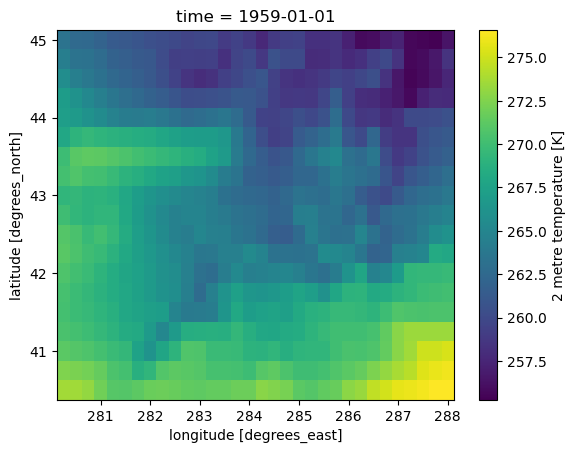

In [5]:
ny_bbox = [360-79.762152, 360-71.856214, 45.01585, 40.496103] # latitudes are not monotonically increasing. Maybe we should raise an issue?
ny_temp = ar_full_37_1h['2m_temperature'].sel(
    longitude=slice(ny_bbox[0],ny_bbox[1]),
    latitude=slice(ny_bbox[2],ny_bbox[3])
)
ny_temp.isel(time=0).plot()

In [6]:
from xhistogram.xarray import histogram
import numpy as np

In [11]:
temp_hist = histogram(
    ny_temp.isel(time=slice(0, 5000)),
    bins=[np.linspace(230, 320, 100)],
    dim=['longitude', 'latitude']
)
temp_hist

<xarray.DataArray 'histogram_2m_temperature' (time: 5000, 2m_temperature_bin: 99)>
dask.array<sum-aggregate, shape=(5000, 99), dtype=int64, chunksize=(1, 99), chunktype=numpy.ndarray>
Coordinates:
  * time                (time) datetime64[ns] 1959-01-01 ... 1959-07-28T07:00:00
  * 2m_temperature_bin  (2m_temperature_bin) float64 230.5 231.4 ... 318.6 319.5

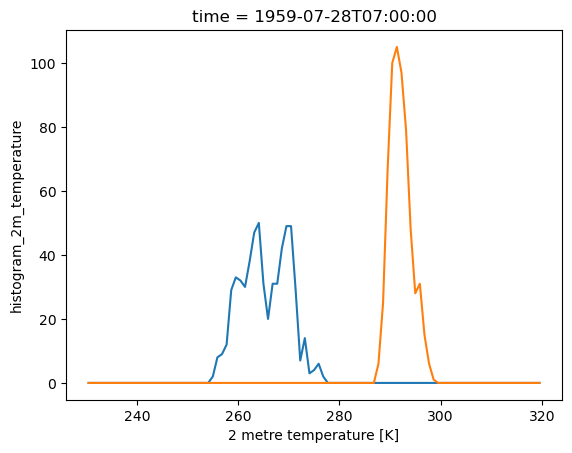

In [12]:
temp_hist.isel(time=0).plot()
temp_hist.isel(time=-1).plot()

In [ ]:
# lets store this output as a zarr store
out_path = 'gs://leap-scratch/jbusecke/annual_meeting_demo/era5/temp_hist.zarr'

from dask.diagnostics import ProgressBar
with ProgressBar():
    temp_hist.to_zarr(out_path, mode='w')
    
# # Bonus points: swap the above with the lines below to get access to the Dask dashboard
# from distributed import Client
# client = Client()
# display(client)
# temp_hist.to_zarr(out_path, mode='w')

# # Dont forget to click the `'Launch dashboard in JupyterLab'` button!

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39341 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/jbusecke/proxy/39341/status,
Dashboard: /user/jbusecke/proxy/39341/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33333,Workers: 4
Dashboard: /user/jbusecke/proxy/39341/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:39809,Total threads: 1
Dashboard: /user/jbusecke/proxy/43325/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:35071,


## Reusing the output

So now you can hand of this store to all your colleagues and everyone can explore the hourly histograms without having to run this long computation.

In [15]:
temp_hist_reloaded = xr.open_dataset(
    out_path,
    engine='zarr',
    chunks=None, # this array is super small, so we can load it directly into memory
)
temp_hist_reloaded

<xarray.Dataset>
Dimensions:                   (2m_temperature_bin: 99, time: 5000)
Coordinates:
  * 2m_temperature_bin        (2m_temperature_bin) float64 230.5 231.4 ... 319.5
  * time                      (time) datetime64[ns] 1959-01-01 ... 1959-07-28...
Data variables:
    histogram_2m_temperature  (time, 2m_temperature_bin) int64 ...

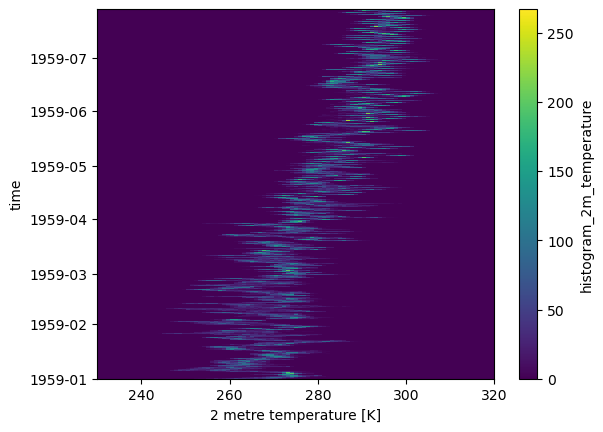

In [16]:
temp_hist_reloaded['histogram_2m_temperature'].plot()